In [3]:
import tensorflow as tf
import datetime, os
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

2023-03-30 11:02:14.498592: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [5]:
def get_image(fp):
    """
    return the 32x32 greyscale array
    """
    img = Image.open(fp)
    return np.asarray(img)


In [6]:
# Create train and test data from csvs in train and test folders
train_data = pd.read_csv('fairface_label_train.csv')[:10000]
test_data = pd.read_csv('fairface_label_train.csv')[:1000]

# Replace the file column with the actual images using get_image function
train_X = np.array([get_image(fp).flatten() for fp in train_data['file']])
test_X = np.array([get_image(fp).flatten() for fp in test_data['file']])

# Get the labels, 0 for Male and 1 for Female
gender_train_Y = np.array([(0,1) if x == 'Female' else (1,0) for x in train_data['gender']])
gender_test_Y = np.array([(0,1) if x == 'Female' else (1,0) for x in test_data['gender']])


# Get the labels
age_train_Y = np.array([np.zeros(9) for x in train_data['age']])
age_test_Y = np.array([np.zeros(9) for x in test_data['age']])

age_dict = {
    '0-2': 0,
    '3-9': 1,
    '10-19': 2,
    '20-29': 3,
    '30-39': 4,
    '40-49': 5,
    '50-59': 6,
    '60-69': 7,
    'more than 70': 8
}

for i, age in enumerate(train_data['age']):
    age_train_Y[i][age_dict[age]] = 1

for i, age in enumerate(test_data['age']):
    age_test_Y[i][age_dict[age]] = 1


# Min max normalize the data
max_val = np.max(train_X)
min_val = np.min(train_X)
train_X = (train_X - min_val) / (max_val - min_val)
test_X = (test_X - min_val) / (max_val - min_val)



## 1: Fully Connected Neural Network

In [7]:
# Feed forward network with:
    # 1024 neurors with tanh act
    # 512 neurons with sig act
    # 100 neurons with relu act
    # n neurons with softmax act
def create_model(n):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(1024, input_shape=(1024,), activation='tanh', name='fc1'))
    model.add(tf.keras.layers.Dense(512, activation='sigmoid', name='fc2'))
    model.add(tf.keras.layers.Dense(100, activation='relu', name='fc3'))
    model.add(tf.keras.layers.Dense(n, activation='softmax', name='output'))
    return model

### 1.1 Gender Classification

In [12]:
gender_model = create_model(2)
gender_model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])

print(gender_model.summary())

logdir = os.path.join("logs/1.1", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

# Train the model
gender_model.fit(x=train_X, 
                 y=gender_train_Y, 
                 epochs=100, 
                 validation_data=(test_X, gender_test_Y),
                 callbacks=[tensorboard_callback])

# Create a heatmap confusion matrix
y_pred = gender_model.predict(test_X)
y_pred = np.argmax(y_pred, axis=1)
y_true = np.argmax(gender_test_Y, axis=1)

# Print the final accuracy
print('Accuracy: ', np.sum(y_pred == y_true) / len(y_true))

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 fc1 (Dense)                 (None, 1024)              1049600   
                                                                 
 fc2 (Dense)                 (None, 512)               524800    
                                                                 
 fc3 (Dense)                 (None, 100)               51300     
                                                                 
 output (Dense)              (None, 2)                 202       
                                                                 
Total params: 1,625,902
Trainable params: 1,625,902
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
313/313 [==============================] - 3s 7ms/step - loss: 0.6814 - accuracy: 0.5662 - val_loss: 0.6821 - val_accuracy: 0.5660
Epoch 2/100
313/313 [=======

KeyboardInterrupt: 

### 1.2 Age Classification

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 fc1 (Dense)                 (None, 1024)              1049600   
                                                                 
 fc2 (Dense)                 (None, 512)               524800    
                                                                 
 fc3 (Dense)                 (None, 100)               51300     
                                                                 
 output (Dense)              (None, 9)                 909       
                                                                 
Total params: 1,626,609
Trainable params: 1,626,609
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
313/313 [==============================] - 3s 8ms/step - loss: 1.8772 - accuracy: 0.2793 - val_loss: 1.8638 - val_accuracy: 0.2470
Epoch 2/10
313/313 [=========

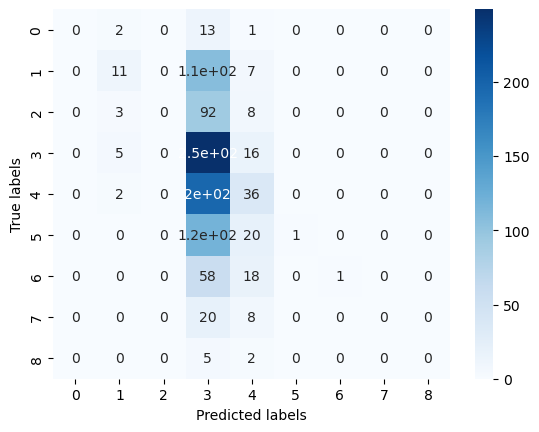

In [7]:
age_model = create_model(9)
age_model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])

print(age_model.summary())

logdir = os.path.join("logs/1.2", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

# Train the model
age_model.fit(x=train_X, 
                 y=age_train_Y, 
                 epochs=10, 
                 validation_data=(test_X, age_test_Y),
                 callbacks=[tensorboard_callback])

# Create a heatmap confusion matrix
y_pred = age_model.predict(test_X)
y_pred = np.argmax(y_pred, axis=1)
y_true = np.argmax(age_test_Y, axis=1)

# Print the final accuracy
print('Accuracy: ', np.sum(y_pred == y_true) / len(y_true))

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

## 2: Small Convolutional Neural Network

In [14]:
"""
Convolution layer having 40 feature detectors, with kernel size 5 x 5, and ReLU
as the activation function, with stride 1 and no-padding.
 A max-pooling layer with pool size 2x2.
 Fully connected layer with 100 neurons, and ReLU as the activation function.
 Output layer: n (depending on the task) neurons representing the n classes, using
the softmax activation function. function for each of the 10 neurons
"""
def create_CNN_model(n):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv2D(40, kernel_size=(5, 5), activation='relu', input_shape=(32,32,1), name='conv1'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2), name='pool1'))
    model.add(tf.keras.layers.Flatten(name='flatten'))
    model.add(tf.keras.layers.Dense(100, activation='relu', name='fc1'))
    model.add(tf.keras.layers.Dense(n, activation='softmax', name='output'))
    return model

### 2.1

In [ ]:
gender_CNN_model = create_CNN_model(2)
gender_CNN_model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])

print(gender_CNN_model.summary())

logdir = os.path.join("logs/2.1", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

# Train the model
gender_CNN_model.fit(x=train_X, 
                 y=age_train_Y, 
                 epochs=100, 
                 validation_data=(test_X, age_test_Y),
                 callbacks=[tensorboard_callback])

# Create a heatmap confusion matrix
y_pred = gender_model.predict(test_X)
y_pred = np.argmax(y_pred, axis=1)
y_true = np.argmax(gender_test_Y, axis=1)

# Print the final accuracy
print('Accuracy: ', np.sum(y_pred == y_true) / len(y_true))

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

In [ ]:
age_CNN_model = create_CNN_model(9)
age_CNN_model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])

print(age_CNN_model.summary())

logdir = os.path.join("logs/2.2", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

# Train the model
age_CNN_model.fit(x=train_X, 
                 y=age_train_Y, 
                 epochs=100, 
                 validation_data=(test_X, age_test_Y),
                 callbacks=[tensorboard_callback])

# Create a heatmap confusion matrix
y_pred = gender_model.predict(test_X)
y_pred = np.argmax(y_pred, axis=1)
y_true = np.argmax(gender_test_Y, axis=1)

# Print the final accuracy
print('Accuracy: ', np.sum(y_pred == y_true) / len(y_true))

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

## 3: Larger Convolutional Neural Network

In [ ]:
def create_custom_CNN_model(n):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv2D(40, kernel_size=(7, 7), activation='relu', input_shape=(32,32,1), name='conv1'))
    model.add(tf.keras.layers.Conv2D(80, kernel_size=(5, 5), activation='relu', name='conv2'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2), name='pool1'))
    model.add(tf.keras.layers.Flatten(name='flatten'))
    model.add(tf.keras.layers.Dense(100, activation='relu', name='fc1'))
    model.add(tf.keras.layers.Dense(n, activation='softmax', name='output'))
    return model

In [ ]:
gender_large_CNN_model = create_CNN_model(2)
gender_large_CNN_model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])

print(gender_large_CNN_model.summary())

logdir = os.path.join("logs/3.1", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

# Train the model
gender_large_CNN_model.fit(x=train_X, 
                 y=age_train_Y, 
                 epochs=100, 
                 validation_data=(test_X, age_test_Y),
                 callbacks=[tensorboard_callback])

# Create a heatmap confusion matrix
y_pred = gender_model.predict(test_X)
y_pred = np.argmax(y_pred, axis=1)
y_true = np.argmax(gender_test_Y, axis=1)

# Print the final accuracy
print('Accuracy: ', np.sum(y_pred == y_true) / len(y_true))

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

## 4: Combined Model

In [13]:
def create_combined_model():
    input = tf.keras.layers.Input(shape=(32, 32, 1))
    conv1 = tf.keras.layers.Conv2D(40, kernel_size=(7, 7), activation='relu', name='conv1')(input)
    conv2 = tf.keras.layers.Conv2D(80, kernel_size=(5, 5), activation='relu', name='conv2')(conv1)
    pool1 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2), name='pool1')(conv2)
    flatten = tf.keras.layers.Flatten()(pool1)

    # Gender branch
    gender_fc1 = tf.keras.layers.Dense(100, activation='relu')(flatten)
    gender_output = tf.keras.layers.Dense(2, activation='softmax')(gender_fc1)

    # Age branch
    age_fc1 = tf.keras.layers.Dense(100, activation='relu')(flatten)
    age_output = tf.keras.layers.Dense(9, activation='softmax')(age_fc1)

    return tf.keras.Model(inputs=input, outputs=[gender_output, age_output])

In [15]:
combined_model = create_combined_model()
combined_model.compile(optimizer='sgd', loss=['categorical_crossentropy', 'categorical_crossentropy'], metrics=['accuracy'])
combined_model.summary()

logdir = os.path.join("logs/4", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

# Train the model
combined_model.fit(x=train_X, 
                 y=age_train_Y, 
                 epochs=100, 
                 validation_data=(test_X, age_test_Y),
                 callbacks=[tensorboard_callback])

# Create a heatmap confusion matrix
y_pred = gender_model.predict(test_X)
y_pred = np.argmax(y_pred, axis=1)
y_true = np.argmax(gender_test_Y, axis=1)

# Print the final accuracy
print('Accuracy: ', np.sum(y_pred == y_true) / len(y_true))

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 32, 32, 1)]  0           []                               
                                                                                                  
 conv1 (Conv2D)                 (None, 26, 26, 40)   2000        ['input_4[0][0]']                
                                                                                                  
 conv2 (Conv2D)                 (None, 22, 22, 80)   80080       ['conv1[0][0]']                  
                                                                                                  
 pool1 (MaxPooling2D)           (None, 11, 11, 80)   0           ['conv2[0][0]']                  
                                                                                            